In [89]:
import numpy as np

In [90]:
coord = [[[304.0133779264214, 255.35117056856186],[309.03010033444815, 255.35117056856186], [321.0702341137124, 256.3545150501672], [332.10702341137124, 257.3578595317726], [345.1505016722408, 257.3578595317726], [351.17056856187287, 257.3578595317726], [356.18729096989966, 257.3578595317726], [358.19397993311037, 257.3578595317726], [360.2006688963211, 256.3545150501672], [360.2006688963211, 253.34448160535115], [360.2006688963211, 246.3210702341137], [360.2006688963211, 237.29096989966555], [358.19397993311037, 226.25418060200667], [355.1839464882943, 218.22742474916387], [349.1638795986622, 211.2040133779264], [344.1471571906354, 205.1839464882943], [336.12040133779266, 201.1705685618729], [331.10367892976586, 200.16722408026754], [326.0869565217391, 200.16722408026754], [322.0735785953177, 200.16722408026754], [318.0602006688963, 203.1772575250836], [316.0535117056856, 209.19732441471572], [315.05016722408027, 218.22742474916387], [313.04347826086956, 246.3210702341137], [313.04347826086956, 273.4113712374582], [313.04347826086956, 304.51505016722405], [313.04347826086956, 325.58528428093643], [313.04347826086956, 353.67892976588627], [311.03678929765886, 373.7458193979933], [307.02341137123744, 385.7859531772575], [303.01003344481603, 395.81939799331104], [294.9832775919732, 403.8461538461538], [284.94983277591973, 410.8695652173913], [270.9030100334448, 415.88628762541805], [255.85284280936455, 418.8963210702341], [241.80602006688963, 418.8963210702341], [229.76588628762542, 418.8963210702341], [219.7324414715719, 413.87959866220734], [213.7123745819398, 409.86622073578593], [205.68561872909697, 401.8394648829431], [202.67558528428094, 395.81939799331104], [201.6722408026756, 390.80267558528425], [200.66889632107024, 386.78929765886284], [200.66889632107024, 381.7725752508361], [202.67558528428094, 377.7591973244147], [208.69565217391303, 374.74916387959865], [215.7190635451505, 371.7391304347826], [224.74916387959865, 370.73578595317724], [230.76923076923077, 370.73578595317724], [235.7859531772575, 370.73578595317724], [238.79598662207357, 370.73578595317724], [239.79933110367892, 370.73578595317724]]]

## Converting coordinates to stroke3

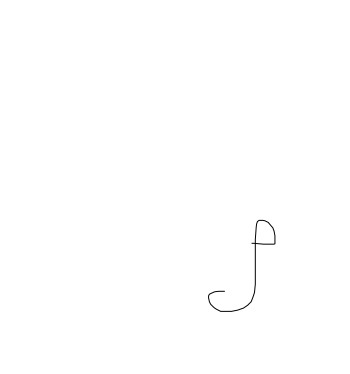

In [91]:
from utils import draw_strokes as draw_strokes

def coords_to_stroke3(coords):
    out = []
    for line in coords:
        for i,point in enumerate(line):
            p =  [float(x)/12 for x in point]
            if i == (len(line)-1):
                p.append(1.0)
            else:
                p.append(0.0)
            out.append(p)
    out = np.array(out)
    out[1:, 0:2] -= out[:-1, 0:2]
    return out

out = coords_to_stroke3(coord)
draw_strokes(out, factor=0.2)


## Predicting the next stroke

In [92]:
# import our command line tools
import tensorflow as tf
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [93]:
models_root_dir = "/Users/bhavika/Desktop/eai/cocreative-drawing/ml_agent/models"
model_dir = '/Users/bhavika/Desktop/eai/cocreative-drawing/ml_agent/models/images'

In [94]:
model_params, eval_model_params, sample_model_params = load_model(model_dir)

In [95]:
tf.compat.v1.disable_eager_execution()
reset_graph()
model = Model(model_params)
eval_model = Model(eval_model_params, reuse=True)
sample_model = Model(sample_model_params, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [96]:
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

In [97]:
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /Users/bhavika/Desktop/eai/cocreative-drawing/ml_agent/models/images/vector-5000.
INFO:tensorflow:Restoring parameters from /Users/bhavika/Desktop/eai/cocreative-drawing/ml_agent/models/images/vector-5000


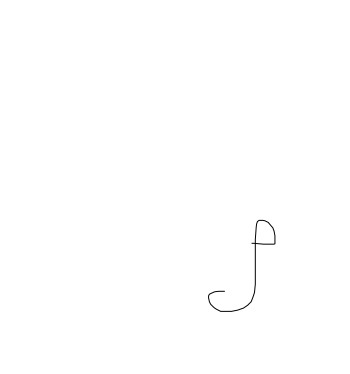

In [98]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes,max_len=eval_model.hps.max_seq_len).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes))[1:], factor=0.2)
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0], strokes

z, stks = encode(out)

In [99]:
def pad_batch(model, batch, max_len):
    """Pad the batch to be stroke-5 bigger format as described in paper."""
    start_stroke_token = [0, 0, 1, 0, 0]
    result = np.zeros((model.hps.batch_size, max_len + 1, 5), dtype=float)
    assert len(batch) == model.hps.batch_size
    for i in range(model.hps.batch_size):
        l = len(batch[i])
        assert l <= max_len
        result[i, 0:l, 0:2] = batch[i][:, 0:2]
        result[i, 0:l, 3] = batch[i][:, 2]
        result[i, 0:l, 2] = 1 - result[i, 0:l, 3]
        result[i, l:, 4] = 1
        # put in the first token, as described in sketch-rnn methodology
        result[i, 1:, :] = result[i, :-1, :]
        result[i, 0, :] = 0
        result[i, 0, 2] = start_stroke_token[2]  # setting S_0 from paper.
        result[i, 0, 3] = start_stroke_token[3]
        result[i, 0, 4] = start_stroke_token[4]
    return result

def sample(sess, model, seq_len=250, temperature=1.0, greedy_mode=False,
           z=None, stks=None,blind=True):
  """Samples a sequence from a pre-trained model."""

  def adjust_temp(pi_pdf, temp):
    pi_pdf = np.log(pi_pdf) / temp
    pi_pdf -= pi_pdf.max()
    pi_pdf = np.exp(pi_pdf)
    pi_pdf /= pi_pdf.sum()
    return pi_pdf

  def get_pi_idx(x, pdf, temp=1.0, greedy=False):
    """Samples from a pdf, optionally greedily."""
    if greedy:
      return np.argmax(pdf)
    pdf = adjust_temp(np.copy(pdf), temp)
    accumulate = 0
    for i in range(0, pdf.size):
      accumulate += pdf[i]
      if accumulate >= x:
        return i
    tf.logging.info('Error with sampling ensemble.')
    return -1

  def sample_gaussian_2d(mu1, mu2, s1, s2, rho, temp=1.0, greedy=False):
    if greedy:
      return mu1, mu2
    mean = [mu1, mu2]
    s1 *= temp * temp
    s2 *= temp * temp
    cov = [[s1 * s1, rho * s1 * s2], [rho * s1 * s2, s2 * s2]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]

  prev_x = np.zeros((1, 1, 5), dtype=np.float32)
  prev_x[0, 0, 2] = 1  # initially, we want to see beginning of new stroke

  if z is None:
    z = np.random.randn(1, model.hps.z_size)  # not used if unconditional

  if not model.hps.conditional:
    prev_state = sess.run(model.initial_state)
  else:
    prev_state = sess.run(model.initial_state, feed_dict={model.batch_z: z})

  len_stks = len(stks)  
  strokes = np.zeros((seq_len, 5), dtype=np.float32)
  mixture_params = []

  greedy = greedy_mode
  temp = temperature

  if not blind:
    for j,stk in enumerate(stks):
        i = j+1  
        dta = pad_batch(sample_model,np.array([[stk]]),1)
        if not model.hps.conditional:
            feed = {
                model.input_x: prev_x,
                model.sequence_lengths: [1],
                model.initial_state: prev_state,
                model.input_data: dta
            }
        else:
            feed = {
                model.input_x: prev_x,
                model.sequence_lengths: [1],
                model.initial_state: prev_state,
                model.batch_z: z,
                model.input_data: dta
            }

        params = sess.run([
            model.pi, model.mu1, model.mu2, model.sigma1, model.sigma2, model.corr,
            model.pen, model.final_state
        ], feed)

        [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, next_state] = params

        idx = get_pi_idx(random.random(), o_pi[0], temp, greedy)

        idx_eos = get_pi_idx(random.random(), o_pen[0], temp, greedy)
        eos = [0, 0, 0]
        eos[idx_eos] = 1

        next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                            o_sigma1[0][idx], o_sigma2[0][idx],
                                            o_corr[0][idx], np.sqrt(temp), greedy)

        params = [
            o_pi[0], o_mu1[0], o_mu2[0], o_sigma1[0], o_sigma2[0], o_corr[0],
            o_pen[0]
        ]

        mixture_params.append(params)

        prev_x = np.zeros((1, 1, 5), dtype=np.float32)
        prev_x[0][0] = np.array(
            [next_x1, next_x2, eos[0], eos[1], eos[2]], dtype=np.float32)
        prev_state = next_state

    strokes = np.zeros((seq_len, 5), dtype=np.float32)
    mixture_params = []

  for i in range(seq_len):
    if not model.hps.conditional:
      feed = {
          model.input_x: prev_x,
          model.sequence_lengths: [1],
          model.initial_state: prev_state
      }
    else:
      feed = {
          model.input_x: prev_x,
          model.sequence_lengths: [1],
          model.initial_state: prev_state,
          model.batch_z: z
      }

    params = sess.run([
        model.pi, model.mu1, model.mu2, model.sigma1, model.sigma2, model.corr,
        model.pen, model.final_state
    ], feed)

    [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, next_state] = params

    idx = get_pi_idx(random.random(), o_pi[0], temp, greedy)

    idx_eos = get_pi_idx(random.random(), o_pen[0], temp, greedy)
    eos = [0, 0, 0]
    eos[idx_eos] = 1

    next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                          o_sigma1[0][idx], o_sigma2[0][idx],
                                          o_corr[0][idx], np.sqrt(temp), greedy)

    strokes[i, :] = [next_x1, next_x2, eos[0], eos[1], eos[2]]

    params = [
        o_pi[0], o_mu1[0], o_mu2[0], o_sigma1[0], o_sigma2[0], o_corr[0],
        o_pen[0]
    ]

    mixture_params.append(params)

    prev_x = np.zeros((1, 1, 5), dtype=np.float32)
    prev_x[0][0] = np.array(
        [next_x1, next_x2, eos[0], eos[1], eos[2]], dtype=np.float32)
    prev_state = next_state
  return strokes, mixture_params

def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.3, seq_len=eval_model.hps.max_seq_len, blind=True):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=seq_len, temperature=temperature, z=z, stks=stks, blind=blind)

  strokes = to_normal_strokes(sample_strokes)
  strokes[-1][2] = 1
  enc_strokes = to_normal_strokes(np.array(stks))

  everything = np.concatenate((strokes,out),0)
  if draw_mode:
    draw_strokes(strokes, factor)
    draw_strokes(out, factor)
    draw_strokes(everything, factor)
  return strokes, everything


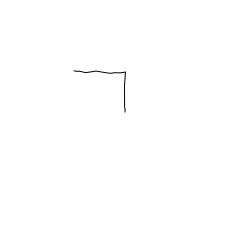

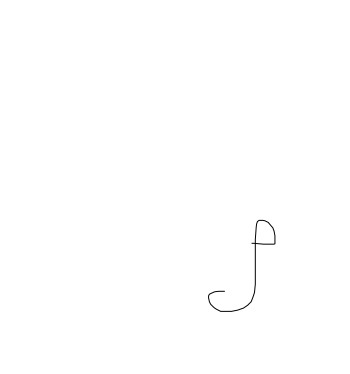

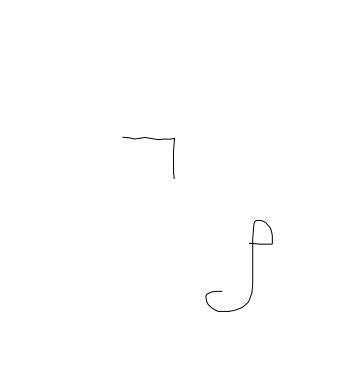

In [160]:
final_strokes,everything = decode(z, temperature=0.9, seq_len=20, factor=0.2, blind=True)

## Converting stroke3 to coordinates

In [194]:
def strokes_to_lines(strokes):
  """Convert stroke-3 format to polyline format."""
  x = 0
  y = 0
  lines = []
  line = []
  min_val = 10000
  for i in range(len(strokes)):
    if strokes[i, 2] == 1:
      x += float(strokes[i, 0])
      y += float(strokes[i, 1])
      line.append([x, y])
      lines.append(line)
      line = []
    else:
      x += float(strokes[i, 0])
      y += float(strokes[i, 1])
      line.append([x, y])
    if x < min_val:
        min_val = x
    if y < min_val:
        min_val = y
  if len(line) >0:
    lines.append(line)
  final = []
  if min_val < 0:
      s = (min_val-50)
  else:
      s = 0
  for line in lines:
      temp = []
      for point in line:
          x *=60
          x = point[0] - s
          y *=60
          y = point[1] - s
          temp.append([x,y])
      final.append(temp)
  return final

strokes_to_lines(final_strokes)

[[[60.319647412747145, 58.907575231045485],
  [60.32520044222474, 58.264929216355085],
  [60.23244350776076, 57.80287964269519],
  [60.22180944029242, 54.44547564908862],
  [60.20643384754658, 53.97618372365832],
  [60.217829778790474, 53.47027487680316],
  [60.40919768810272, 50.791519831866026],
  [59.40379285812378, 50.94604740664363],
  [58.91481274366379, 50.93885562196374],
  [58.31089460849762, 50.90893288142979],
  [57.47209048271179, 51.03233147598803],
  [56.784695625305176, 50.96950362063944],
  [54.513421058654785, 50.593714186921716],
  [53.84723615646362, 50.69421117939055],
  [53.14482653141022, 50.797006072476506],
  [52.424728870391846, 50.90632431395352],
  [51.78930473327637, 50.75759673304856],
  [51.16265791654587, 50.6241097766906],
  [50.64729219675064, 50.634784762747586],
  [50.0, 50.5272914217785]]]

In [198]:
def strokes_to_lines(strokes):
  """Convert stroke-3 format to polyline format."""
  x = 0
  y = 0
  lines = []
  line = []
  for i in range(len(strokes)):
    if strokes[i, 2] == 1:
        x += float(strokes[i, 0])
        y += float(strokes[i, 1])
        line.append([x, y])
        lines.append(line)
        line = []
    else:
        x += float(strokes[i, 0])
        y += float(strokes[i, 1])
        line.append([x, y])
  if len(line) >0:
    lines.append(line)
  lines = np.array(lines).astype(float)
  lines = lines*12.0
  min_val = float(np.amin(lines)) -50.0
  lines = lines - min_val
  lines = lines.tolist()
  return lines

strokes_to_lines(final_strokes)

[[[173.83576895296574, 156.89090277254581],
  [173.9024053066969, 149.17915059626102],
  [172.78932209312916, 143.63455571234226],
  [172.66171328350902, 103.34570778906345],
  [172.47720617055893, 97.71420468389988],
  [172.6139573454857, 91.64329852163792],
  [174.91037225723267, 59.49823798239231],
  [162.84551429748535, 61.35256887972355],
  [156.97775292396545, 61.26626746356487],
  [149.73073530197144, 60.9071945771575],
  [139.6650857925415, 62.387977711856365],
  [131.4163475036621, 61.63404344767332],
  [104.16105270385742, 57.12457024306059],
  [96.16683387756348, 58.330534152686596],
  [87.73791837692261, 59.564072869718075],
  [79.09674644470215, 60.875891767442226],
  [71.4716567993164, 59.0911607965827],
  [63.951894998550415, 57.48931732028723],
  [57.76750636100769, 57.61741715297103],
  [50.0, 56.327497061342]]]

In [208]:
def strokes_to_lines(strokes):
    """Convert stroke-3 format to polyline format."""
    x = 0
    y = 0
    lines = []
    line = []
    for i in range(len(strokes)):
        if strokes[i, 2] == 1:
            x += float(strokes[i, 0])
            y += float(strokes[i, 1])
            line.append([x, y])
            lines.append(line)
            line = []
        else:
            x += float(strokes[i, 0])
            y += float(strokes[i, 1])
            line.append([x, y])
    if len(line) >0:
        lines.append(line)

    min_val = 0
    final_lines = []
    for line in lines:
   
        line = np.array(line).astype(float)
        line = line*12.0

        temp_min_val = float(np.amin(line))
        if temp_min_val < min_val:
            min_val = temp_min_val
        line = line.tolist()
        final_lines.append(line)
    scaled_final_lines = []
    for line in final_lines:    
        line = np.array(line).astype(float)
        line -= (min_val-50)
        line = line.tolist()
        scaled_final_lines.append(line)
    return scaled_final_lines

strokes_to_lines(final_strokes)

-6.190905824303627


[[[173.83576895296574, 156.89090277254581],
  [173.9024053066969, 149.17915059626102],
  [172.78932209312916, 143.63455571234226],
  [172.66171328350902, 103.34570778906345],
  [172.47720617055893, 97.71420468389988],
  [172.6139573454857, 91.64329852163792],
  [174.91037225723267, 59.49823798239231],
  [162.84551429748535, 61.35256887972355],
  [156.97775292396545, 61.26626746356487],
  [149.73073530197144, 60.9071945771575],
  [139.6650857925415, 62.387977711856365],
  [131.4163475036621, 61.63404344767332],
  [104.16105270385742, 57.12457024306059],
  [96.16683387756348, 58.330534152686596],
  [87.73791837692261, 59.564072869718075],
  [79.09674644470215, 60.875891767442226],
  [71.4716567993164, 59.0911607965827],
  [63.951894998550415, 57.48931732028723],
  [57.76750636100769, 57.61741715297103],
  [50.0, 56.327497061342]]]